# Choose the device

In [1]:
# setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Load RoBERTa

In [2]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.7 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.5 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# importing libraries for neural network
import torch
from transformers import RobertaModel

In [4]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, 
                           attention_mask=attention_mask, 
                           token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        output = self.classifier(pooler)
        return output

In [5]:
model = RobertaClass()
model.to(device)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

# Load data

You can download dataset [here](https://www.kaggle.com/kazanova/sentiment140)

In [6]:
from google.colab import drive
# connect with your google drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [7]:
import pandas as pd
# paste your path to the dataset
!cp '/content/drive/MyDrive/Colab Notebooks/BroutonLab/Article/dataset.zip' dataset.zip

In [8]:
# unzip files from archive
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [9]:
# Colab Notebooks/Work/Article/

# Prepare data

In [10]:
# drop unnecessary columns and rename the remaining ones
full_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', 
                        encoding='latin-1').drop(["1467810369",
                                                  "Mon Apr 06 22:19:45 PDT 2009",
                                                  "NO_QUERY","_TheSpecialOne_"],
                                                 axis=1).dropna()
columns_names = list(full_data)
full_data.rename(columns={columns_names[0]:"label",
                        columns_names[1]:"text"}, inplace= True)

In [11]:
NUM_SAMPLES = 30000
# separate the positive and negative tweets and take NUM_SAMPLES from them
negative_samples = full_data[full_data["label"]==0][:NUM_SAMPLES]
positiv_samples = full_data[full_data["label"]==4][:NUM_SAMPLES]

In [12]:
# replace label 4 with label 1 because the neural network outputs only 0 or 1
positiv_samples["label"]=[1]*NUM_SAMPLES

In [13]:
# concat back to one dataset
full_data = pd.concat([negative_samples,  positiv_samples])

In [14]:
full_data

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
829994,1,"Really wants to go and see 17 again, because Z..."
829995,1,@krissa22 Thank you!
829996,1,dreaming of you
829997,1,@TheEllenShow I saw a clip online! good show!


In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, test_size=0.3)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# information about dataset
print("FULL Dataset: {}".format(full_data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))



FULL Dataset: (60000, 2)
TRAIN Dataset: (42000, 2)
TEST Dataset: (18000, 2)


In [16]:
from transformers import RobertaTokenizer

In [17]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', 
                                             truncation=True, 
                                             do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [18]:
MAX_LEN = 130
train_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in train_data['text']]
test_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in test_data['text']]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Prepare dataset

In [19]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32      
LEARNING_RATE = 1e-05

In [20]:
from torch.utils.data import Dataset, DataLoader

class SentimentData(Dataset):
    def __init__(self, data, inputs_tokenized):
        self.inputs = inputs_tokenized
        self.text = data['text']
        self.targets = data['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        
        input = self.inputs[index]
        ids = input['input_ids']
        mask = input['attention_mask']
        token_type_ids = input['token_type_ids']

        return {
            'sentence': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = SentimentData(train_data, train_tokenized_data)
test_dataset = SentimentData(test_data, test_tokenized_data)

In [21]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

# Fine-tuning model

In [22]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [23]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

test_answers = [[[],[]], [[],[]]]

def train_loop(epochs):
  for epoch in range(epochs):
    for phase in ['Train', 'Test']:
      if(phase == 'Train'):
        model.train()
        loader = train_loader
      else:
        model.eval()
        loader = test_loader  
      epoch_loss = 0
      epoch_acc = 0
      for steps, data in tqdm(enumerate(loader, 0)):
        sentence = data['sentence']
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model.forward(ids, mask, token_type_ids)

        loss = loss_function(outputs, targets)        
        
        epoch_loss += loss.detach()
        _, max_indices = torch.max(outputs.data, dim=1)
        bath_acc = (max_indices==targets).sum().item()/targets.size(0)
        epoch_acc += bath_acc

        if (phase == 'Train'):
          train_loss.append(loss.detach()) 
          train_accuracy.append(bath_acc)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        else:
          test_loss.append(loss.detach()) 
          test_accuracy.append(bath_acc)
          if epoch == epochs-1:
            for i in range(len(targets)):
              test_answers[targets[i].item()][max_indices[i].item()].append([sentence[i], 
                                                                 targets[i].item(), 
                                                                 max_indices[i].item()])

      print(f"{phase} Loss: {epoch_loss/steps}")
      print(f"{phase} Accuracy: {epoch_acc/steps}")

In [24]:
EPOCHS = 4
train_loop(EPOCHS)

1313it [27:45,  1.27s/it]


Train Loss: 0.37769362330436707
Train Accuracy: 0.8323170731707317


563it [04:25,  2.12it/s]


Test Loss: 0.30662792921066284
Test Accuracy: 0.8734986654804271


1313it [27:44,  1.27s/it]


Train Loss: 0.2858887314796448
Train Accuracy: 0.8824552210365854


563it [04:25,  2.12it/s]


Test Loss: 0.3246062994003296
Test Accuracy: 0.8694951067615658


1313it [27:44,  1.27s/it]


Train Loss: 0.23274224996566772
Train Accuracy: 0.9074885670731707


563it [04:25,  2.12it/s]


Test Loss: 0.31412824988365173
Test Accuracy: 0.8787811387900356


1313it [27:45,  1.27s/it]


Train Loss: 0.18700234591960907
Train Accuracy: 0.928734756097561


563it [04:26,  2.11it/s]

Test Loss: 0.3407975733280182
Test Accuracy: 0.8727201957295374


# Visualizing sentiment analysis

In [25]:
print('False Negative:\n', test_answers[1][0][0], "\n", test_answers[1][0][1], "\n", test_answers[1][0][2], "\n",
      '\nFalse Positive:\n', test_answers[0][1][0], '\n', test_answers[0][1][1], '\n', test_answers[0][1][2], '\n')

False Negative:
 ['Searching for a good simple RNG, came across really old Usenet postings. People were real assholes back then', 1, 0] 
 ["@_ophelia danny wasn't there just angela, craig and Robert!! Was a great day though", 1, 0] 
 ["#mmuk09 lots of interesting conversations over the lunch break. now, where's @andyramsden ?!", 1, 0] 
 
False Positive:
 ['@AllyAyr Although, Menthol Cigs are vile also.', 0, 1] 
 ['@jacvanek are you a superpupermegaovermodel? sorry idk precisely but thank you for adding me here and on myspace ;P', 0, 1] 
 ['@mojojuju , walk, stumble, curse your way outside, down the driveway, past the chicken coup, keep going, almost there. Outhouse...', 0, 1] 



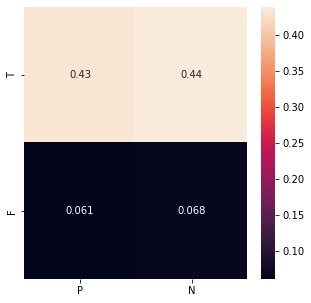

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

len_num = len(test_dataset)

tp=len(test_answers[1][1])/len_num
fn=len(test_answers[1][0])/len_num
fp=len(test_answers[0][1])/len_num
tn=len(test_answers[0][0])/len_num

array_matrix = [[tp,tn], 
                [fp,fn]]
df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                  columns = ['P', 'N'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

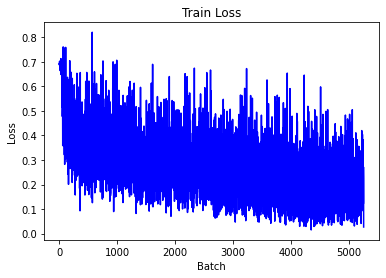

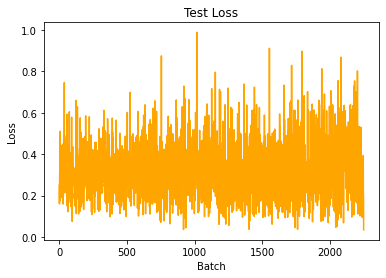

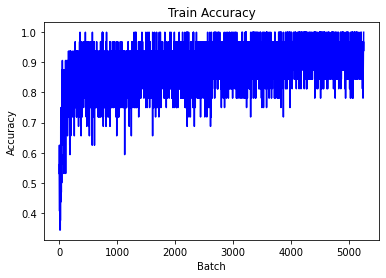

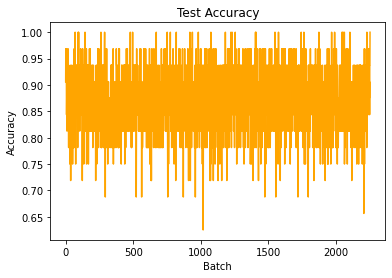

In [27]:
plt.plot(train_loss,  color='blue')
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(test_loss,  color='orange')
plt.title("Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")      
plt.show()

plt.plot(train_accuracy,  color='blue')
plt.title("Train Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
plt.show()

plt.plot(test_accuracy,  color='orange')
plt.title("Test Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
 
plt.show()

<a id='section07'></a>
### Save model

In [28]:
save_path="./"
torch.save(model, save_path+'trained_roberta.pt')
print('All files saved')
print('Congratulations, you complete this tutorial')

All files saved
Congratulations, you complete this tutorial
